# Practical Session - Unsupervised Learning

MOREIRA TEIXEIRA Luiz Fernando

This Practical session is about unsupervised learning, and more specifically about dimensionality reduction using the PCA and ICA algorithms. You will first work on toy examples, and then apply the methods on a real face dataset.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`). 

First let's load the functions we will use

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm


import math

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scipy.io import loadmat

# I - Toy examples
## I - 1) Dataset generation

As mentionned, you will first work on toy datasets. The next three functions are used to generate the data and plot the results.

In [2]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1: 
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T
        
        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)
    
    N0=np.sum(y==0)
    N1=np.sum(y==1)
    
    fig=plt.figure(figsize=(17, 6))
    
    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()
    
    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')
    
    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')
    
    plt.show()
    
    
def frontiere(model, X, y, step=50):

    labels = np.unique(y)
 
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)
   
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')
    
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1') 
    
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    

Now,let's create the data we will use.
Try the 4 different scenarios by simply varying the `scenarioIndex` value between 1 and 4.

**Question** : what does each scenario corresponds to?

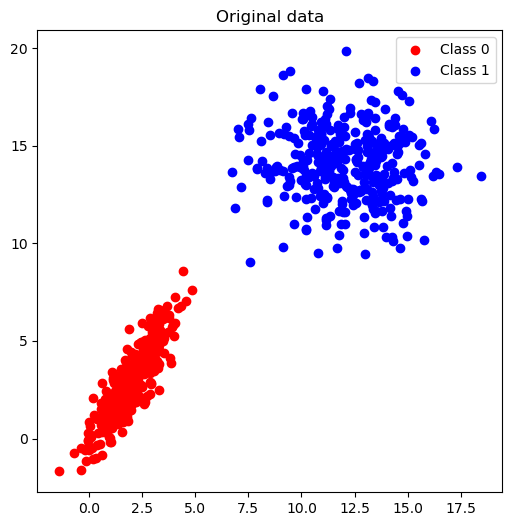

In [3]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 1
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)


plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

## I - 2) PCA

**BASIC PCA**

It's time to start using the methods seen in class. Let's start with PCA. 


As you can see, we have generated two populations (class 0 and class 1). We concatenate them as a single matrix *X* which will be the input for all methods. In this way, the methods will be unaware of the class of the observations (unsupervised) and we will test whether the methods are appropriate for the analysed scenario and if they are able to use less dimensions to correctly distinguish the two classes. 


**Question:**
1. Use PCA with the different 4 scenarios and comment the results. When does PCA work well ? Why ? Expain.

We can check the variance explained of each case, the closer to 1, it means that our data is being well represented, 0.96 for the first case and 0.97 for the second case. So from our results below we check that for cases 1 and 2 PCA works well on the data. As for cases 3 and 4 it doesn't work very well and probably requires a technique like the Kernel PCA or the ICA.

The variance explained by the two first modes is respectively:  [0.96287347 0.03712653]


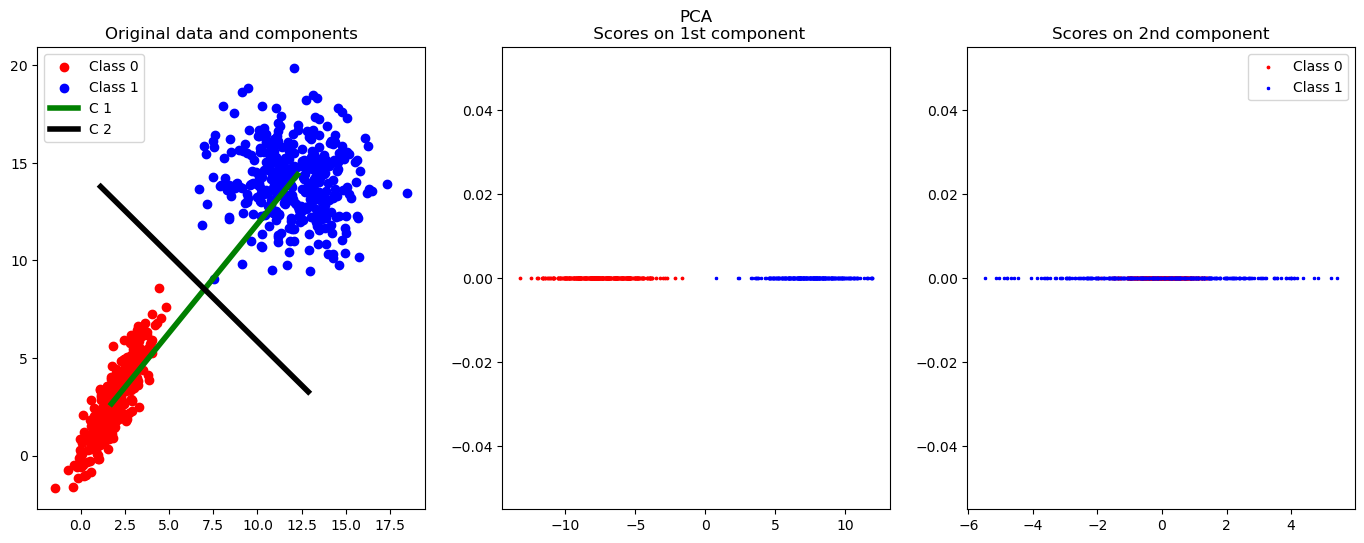

In [4]:
## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca.explained_variance_ratio_)
plotResults(X0,X1,y,U,Ypca,const=1,title='PCA')

The variance explained by the two first modes is respectively:  [0.97183883 0.02816117]


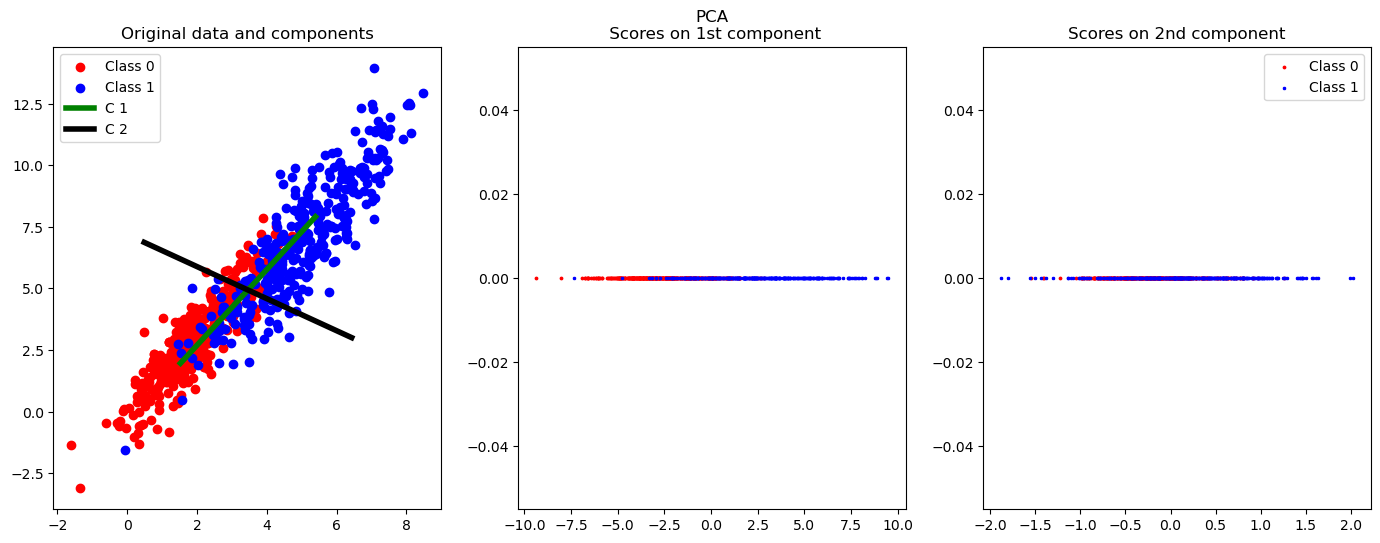

In [5]:
scenarioIndex = 2
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca.explained_variance_ratio_)
plotResults(X0,X1,y,U,Ypca,const=1,title='PCA')

The variance explained by the two first modes is respectively:  [0.63084599 0.36915401]


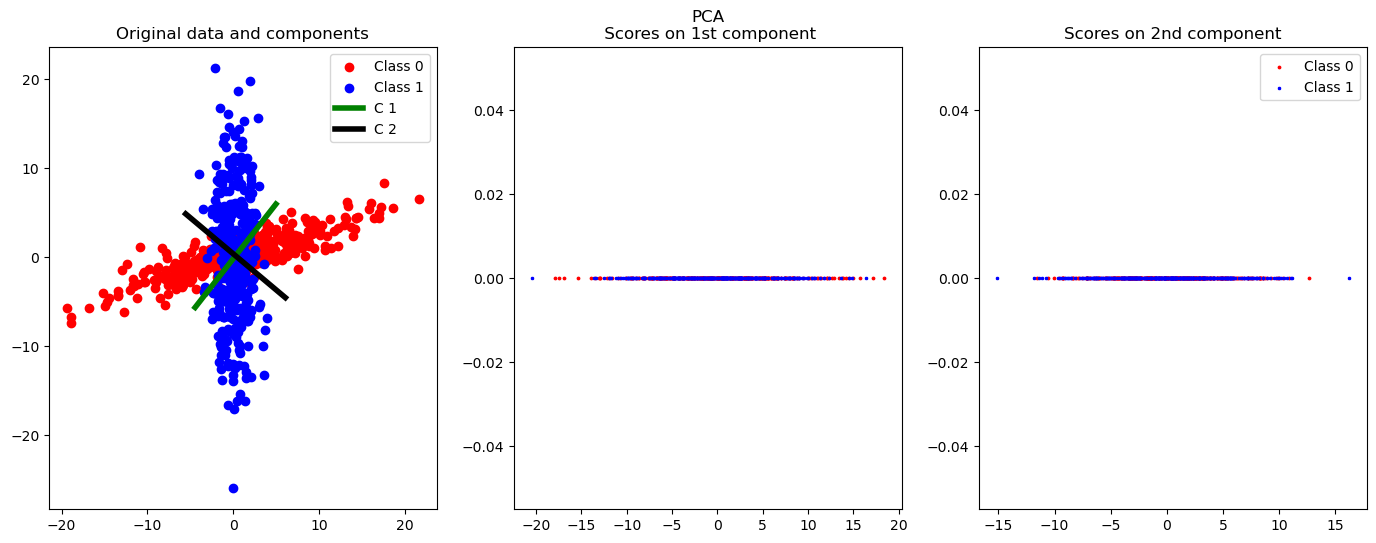

In [6]:
scenarioIndex = 3
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca.explained_variance_ratio_)
plotResults(X0,X1,y,U,Ypca,const=1,title='PCA')

The variance explained by the two first modes is respectively:  [0.50142558 0.49857442]


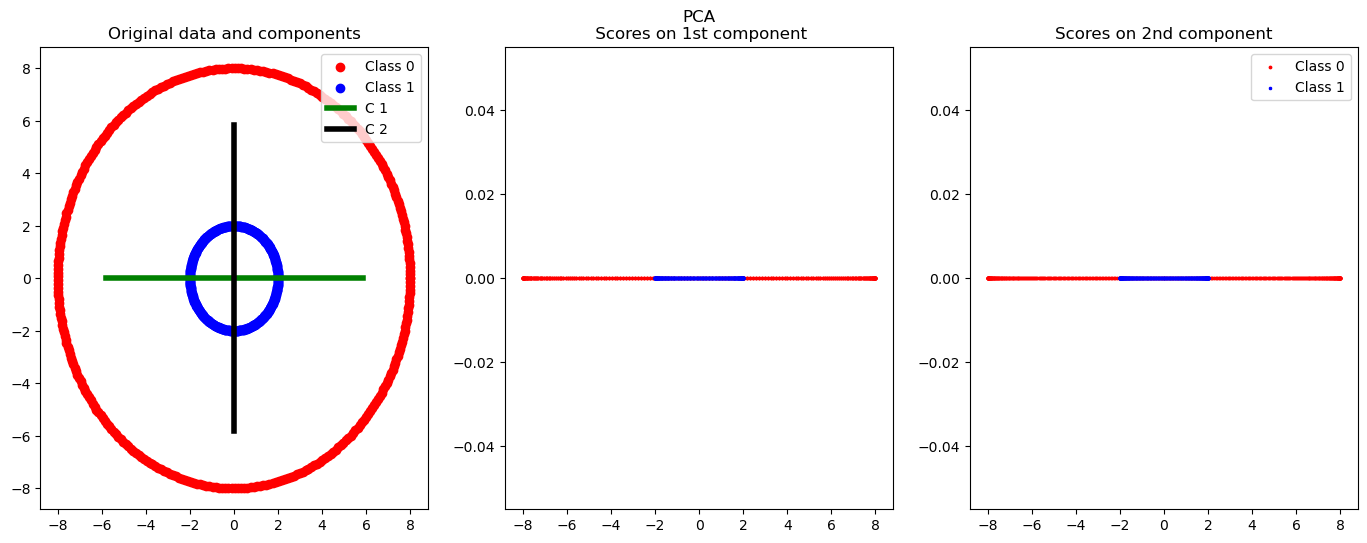

In [7]:
scenarioIndex = 4
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca.explained_variance_ratio_)
plotResults(X0,X1,y,U,Ypca,const=1,title='PCA')

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

In [8]:
def pcaLecture(X):
    ''' 
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
              column consists of features.
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of X onto the new basis given by the eigenvactors U
            of the covariance matrix of X. Columns are the principal components.
               
            U: columns are Eigenvectors (sorted from the greatest to the lowest eigenvalue)
    
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)
               
            var_explained: percentage of the original variability explained
            by each principal component.
    '''
    
    N=X.shape[0]
    Xc = X - np.mean(X, axis=0) # centering

    C = (1/(N - 1)) * Xc.T @ Xc # Covariance Matrix
    
    D, U = np.linalg.eig(C) # Get the eigenvalues and eigenvectors directly from C
    
    Y = Xc @ U  # Projection of the Data into U
    
    tot=np.sum(D)
    var_explained = D/tot # computation of explained variance - used to determine k
    return Y,U,D,var_explained


**Question:**
1. Test your own implementation and check whether the results are the same of the scikit-learn implementation

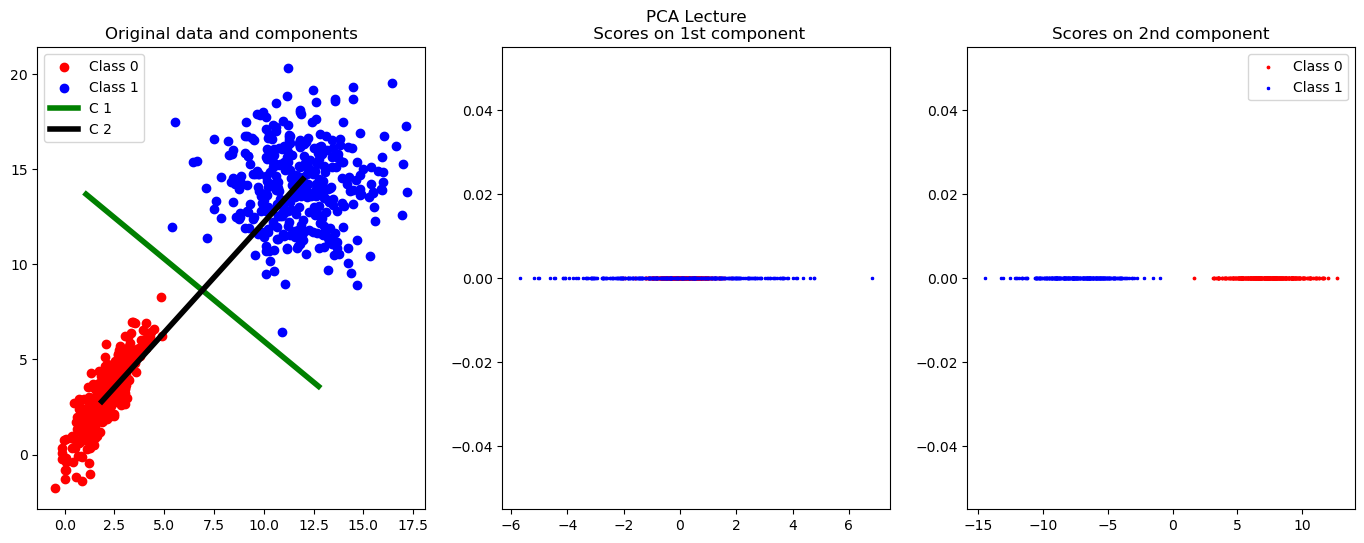

In [9]:
scenarioIndex = 1
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)
plotResults(X0,X1,y,UpcaLec,YpcaLec,const=1,title='PCA Lecture')


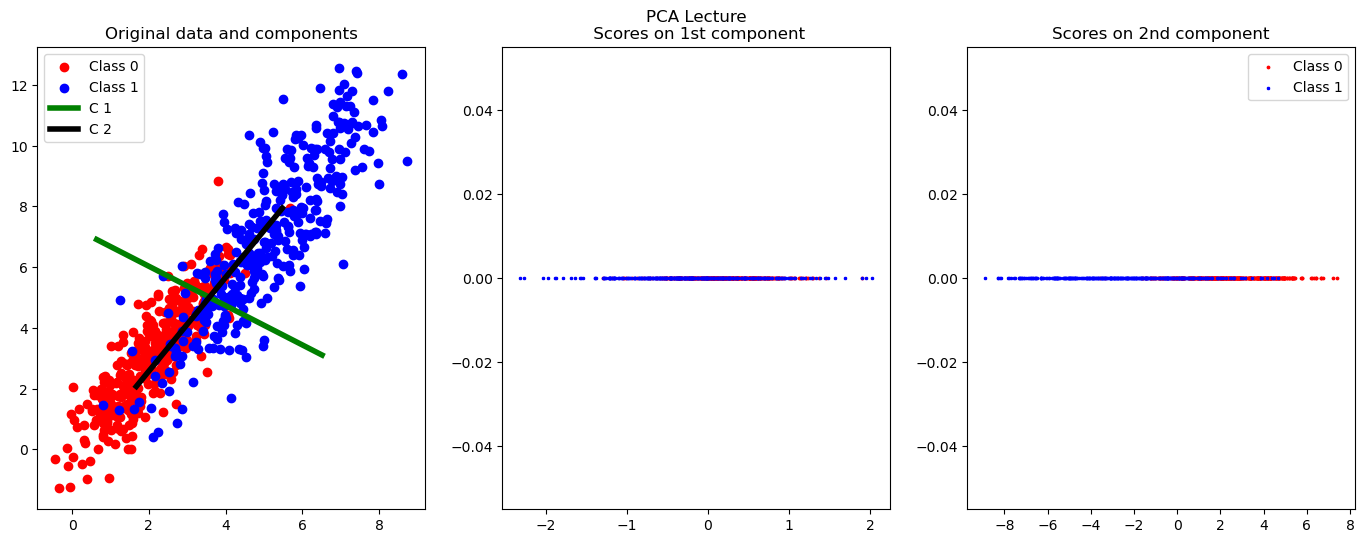

In [10]:
scenarioIndex = 2
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)
plotResults(X0,X1,y,UpcaLec,YpcaLec,const=1,title='PCA Lecture')


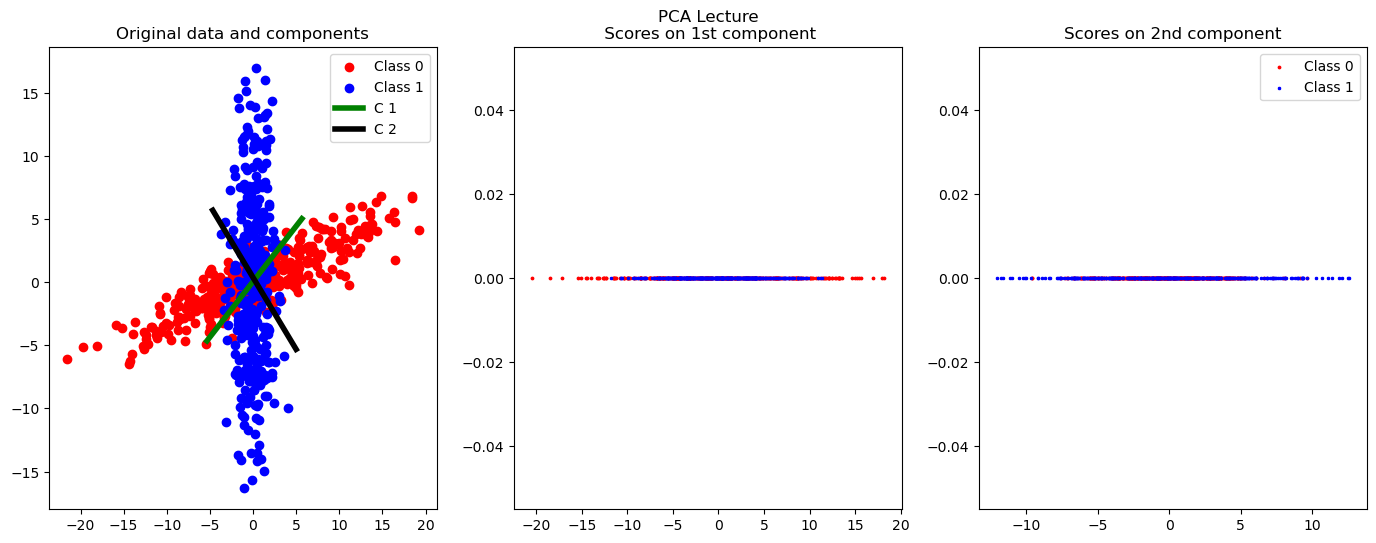

In [11]:
scenarioIndex = 3
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)
plotResults(X0,X1,y,UpcaLec,YpcaLec,const=1,title='PCA Lecture')


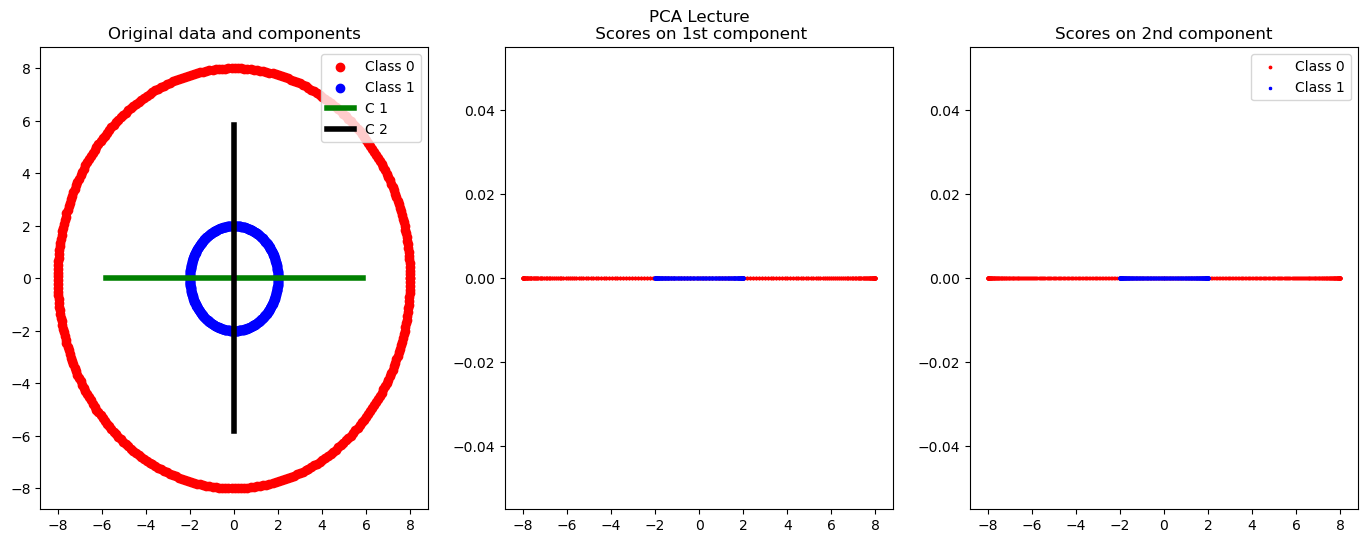

In [12]:
scenarioIndex = 4
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)
plotResults(X0,X1,y,UpcaLec,YpcaLec,const=1,title='PCA Lecture')


**KERNEL PCA**

Let's now use Kernel-PCA with the rbf kernel (you can also test other kernels if you want).

**Question:**
1. What is the interest of kernel PCA over the basic PCA?

The regular PCA has the limitation of only being able to capture linear models. Thus when we have data that can't be represented linearly PCA won't work. In this case the Kernel PCA works by first projecting the data into a higher-dimension before applying the regular PCA. In this way we can obtain a more trustful representation of the data.

3. Use Kernel-PCA with the different 4 scenarios and comment the results. When does K-PCA work well ? Why ?

It appears to only work well in the first and third scenario, its where we can see the data separation represented on the first mode of these cases. 


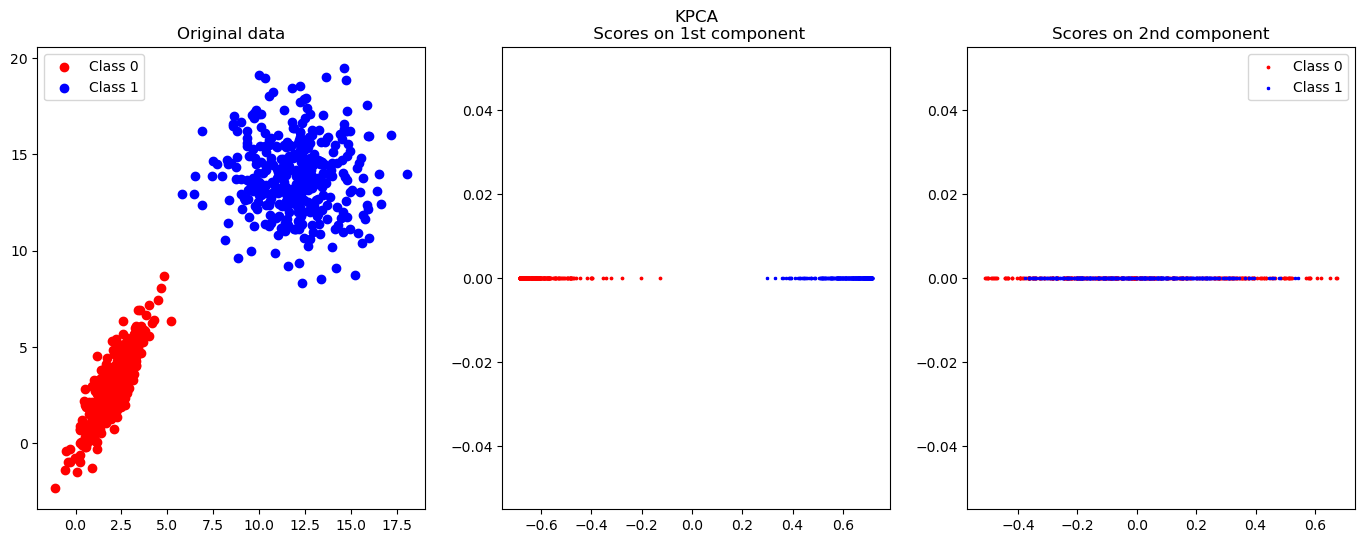

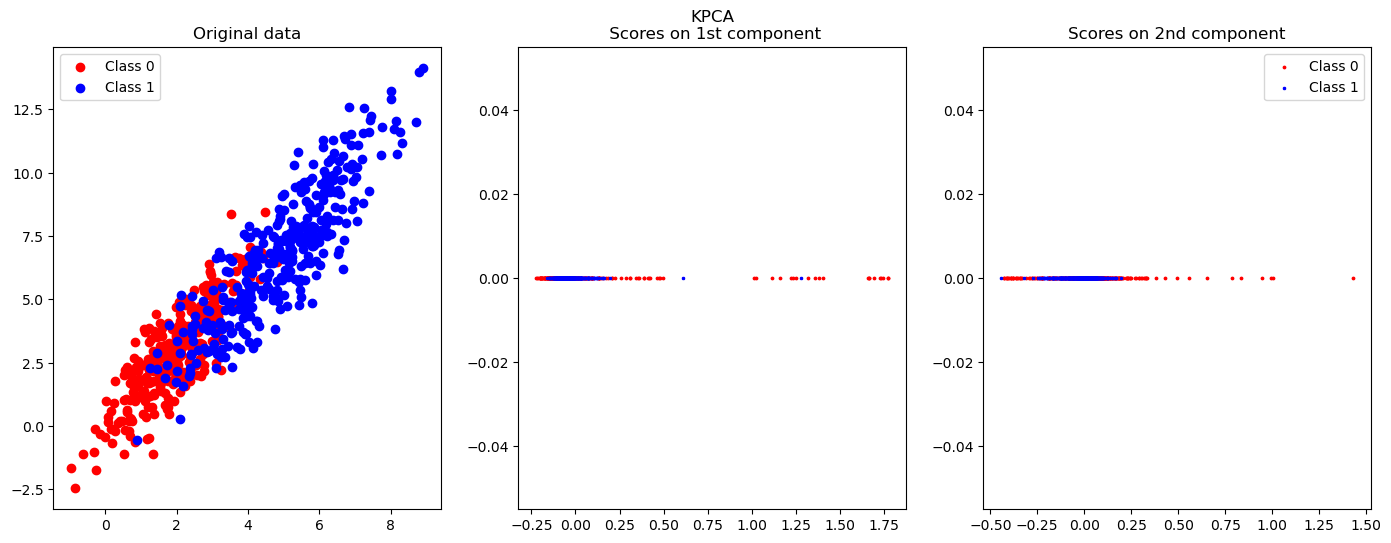

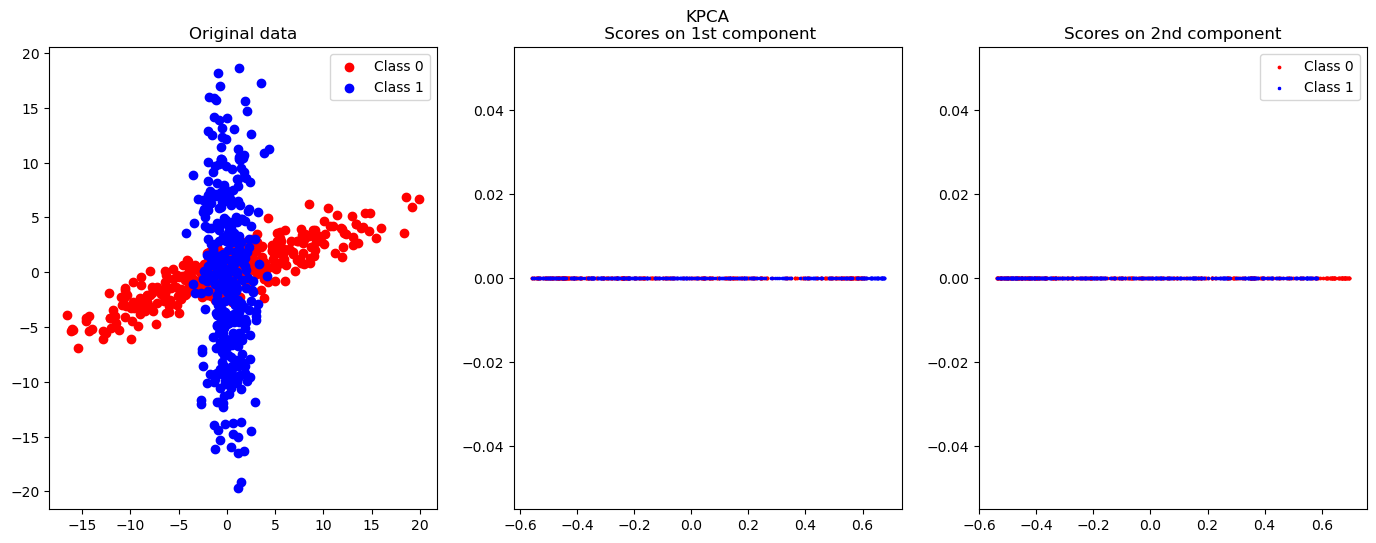

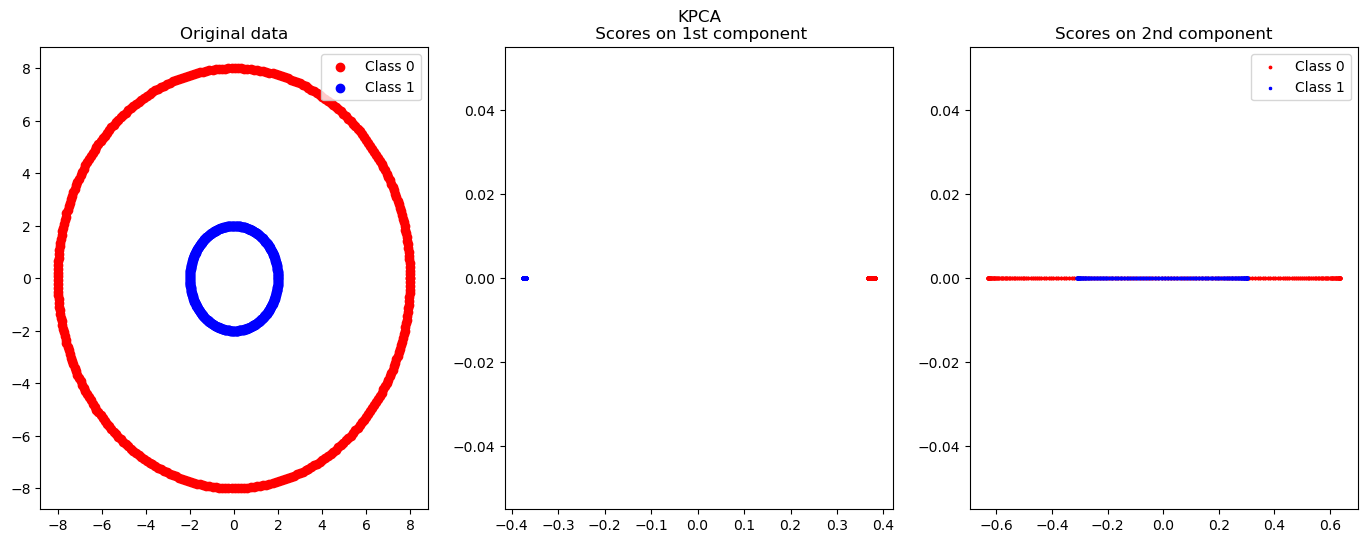

In [13]:
# Kernel-PCA
scenarioIndex = 1
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
gamma=0.02
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.eigenvalues_
AKpca=Kpca.eigenvectors_

plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')

scenarioIndex = 2
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
gamma= None
Kpca = KernelPCA(kernel='cosine', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.eigenvalues_
AKpca=Kpca.eigenvectors_

plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')


scenarioIndex = 3
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
gamma=0.02
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.eigenvalues_
AKpca=Kpca.eigenvectors_

plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')


scenarioIndex = 4
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
gamma=0.02
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.eigenvalues_
AKpca=Kpca.eigenvectors_

plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')


**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

In [14]:
def KpcaGaussianLecture(X,gamma):
    '''  
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
            column is a feature.
 
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of \phi(X) onto the new basis given by the eigenvactors 
            of the covariance matrix of \phi(X). Columns are the principal components.

            An: columns are Eigenvectors normalised (sorted from the greatest
            to the lowest eigenvalue)
     
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)

            var_explained: percentage of the original variability explained
            by each principal component.

    '''

    # kernel matrix using a rbf kernel 
    def kernel_matrix(X,gamma):
      N=X.shape[0]
      InnerX = np.dot(X,X.T)
      temp1=np.sum(X**2,axis=1).reshape((N,1))
      temp2=np.sum(X**2,axis=1).reshape((1,N))
      Norm1 = np.repeat(temp1,N,axis=1)
      Norm2 = np.repeat(temp2,N,axis=0) 
      Norm = Norm1+Norm2-2*InnerX;
      Norm[Norm<1e-10]=0;    
      K=np.exp(-Norm/(2*gamma**2))
      return K
       
    N=X.shape[0]

    K= kernel_matrix(X, gamma)
    
    # center kernel matrix
    oneN=np.ones((N,N))/N;
    Kc= K - oneN @ K - K @ oneN + oneN @ K @ oneN # center kernel matrix

    # eigenvalue analysis
    D,A=LA.eigh(Kc)     
    idx = D.argsort()[::-1]  # reverse order to make 'descend' 
    D = np.real(D[idx])
    D[D<0]=1e-18 # make negative eigenvalues positive (and almost 0)
    A = np.real(A[:,idx])

    # variance explained
    tot=np.sum(D)
    var_explained = D/tot # computation of explained variance

    # Normalisation eigenvectors
    # Norm of every eigenvector is 1, we want it to be 1/sqrt(N*eig)
    
    An=np.copy(A)
    for i in range(N):      
        An[:,i]=np.dot(A[:,i],(1/np.sqrt((N-1)*D[i])) )          
           
    Y =  Kc @ An  # computation of the scores  
    
    return Y,An,D,var_explained


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_130839/3631417567.py:2: SyntaxWarning: invalid escape sequence '\p'
  '''


Test your own implementation

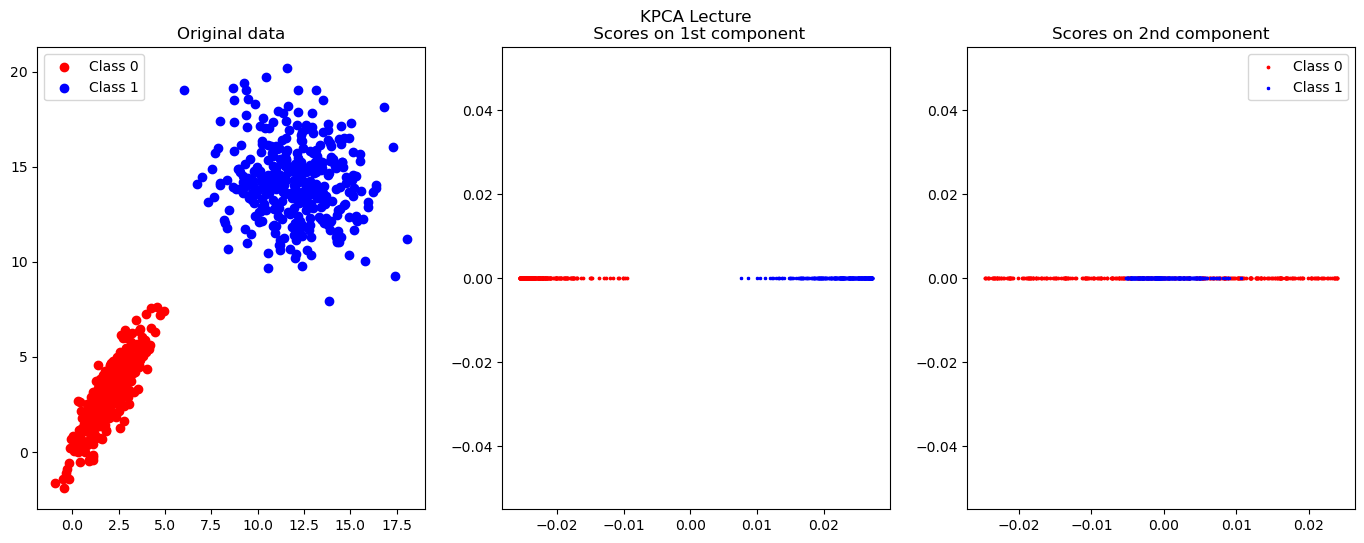

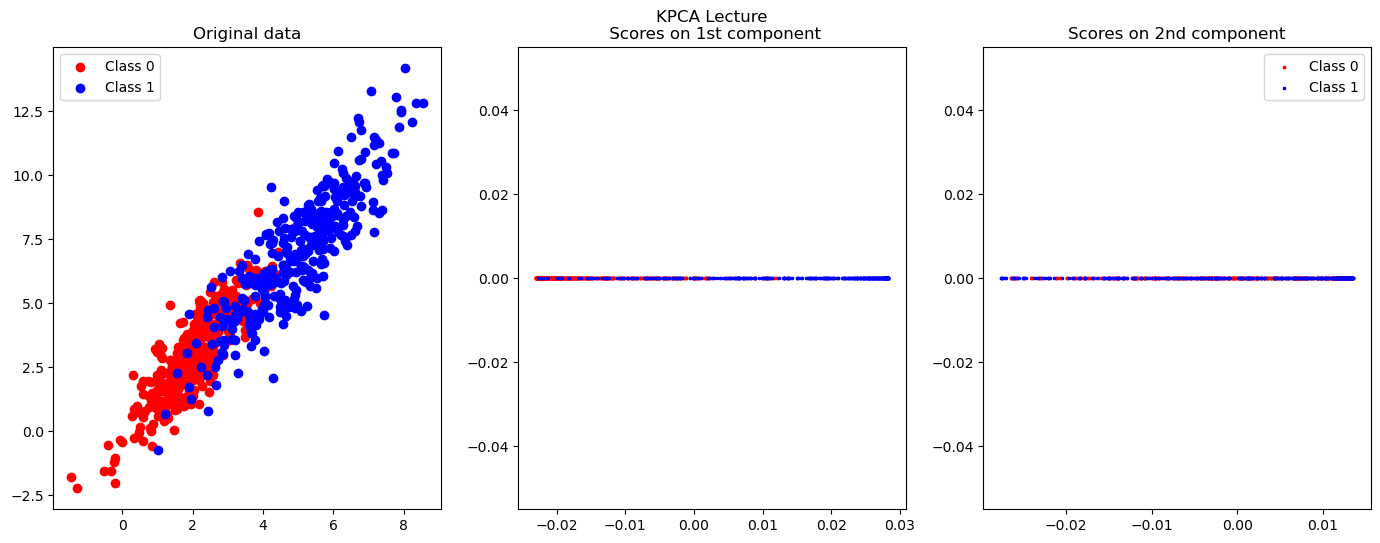

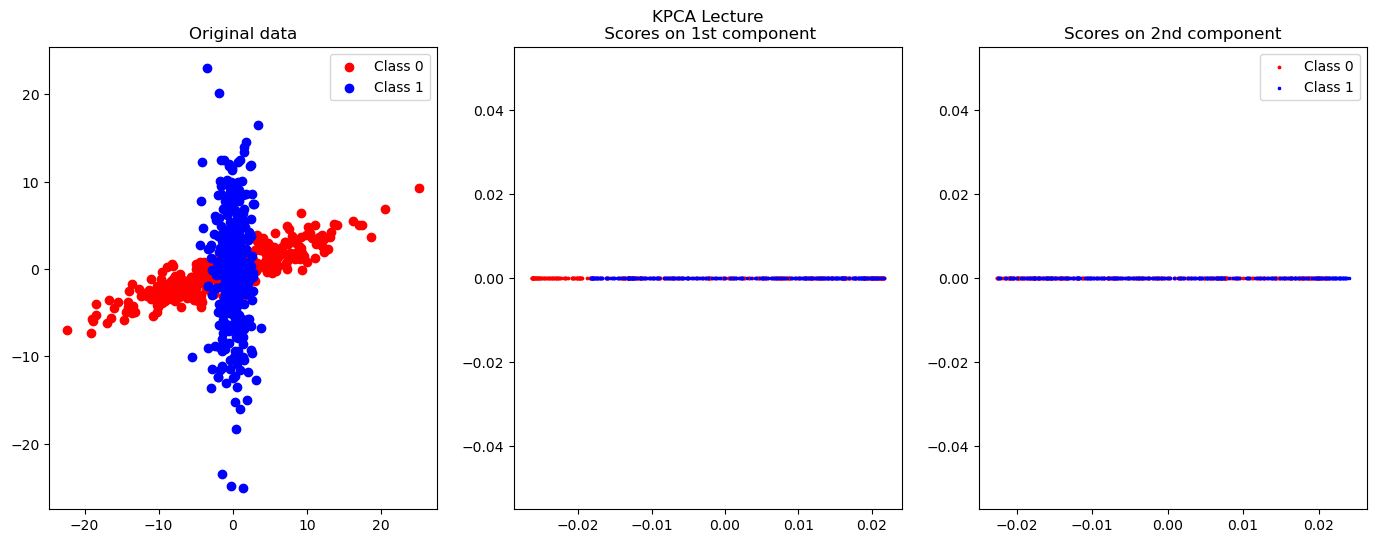

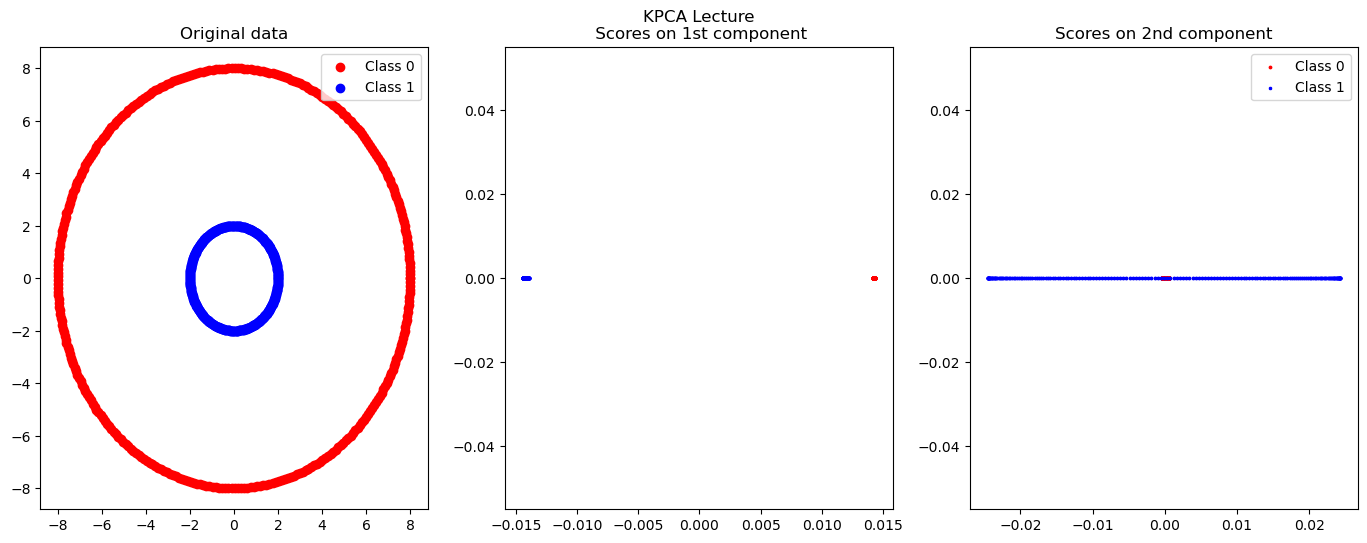

In [15]:
scenarioIndex = 1
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
gamma = 4
YKpcaLec, AnKpcaLec, DKpcaLec, var_explainedKpca = KpcaGaussianLecture(X,gamma) # Please pay attention to the fact that gamma is not the same in scikit implementation and ours. In scikit, gamma = 1/(2 sigma^2) and -gamma || x - y ||^2 is used
plotResults(X0=X0,X1=X1,y=y,Y=YKpcaLec,const=1,title='KPCA Lecture')


scenarioIndex = 2
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
gamma = 4
YKpcaLec, AnKpcaLec, DKpcaLec, var_explainedKpca = KpcaGaussianLecture(X,gamma) # Please pay attention to the fact that gamma is not the same in scikit implementation and ours. In scikit, gamma = 1/(2 sigma^2) and -gamma || x - y ||^2 is used
plotResults(X0=X0,X1=X1,y=y,Y=YKpcaLec,const=1,title='KPCA Lecture')

scenarioIndex = 3
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
gamma = 4
YKpcaLec, AnKpcaLec, DKpcaLec, var_explainedKpca = KpcaGaussianLecture(X,gamma) # Please pay attention to the fact that gamma is not the same in scikit implementation and ours. In scikit, gamma = 1/(2 sigma^2) and -gamma || x - y ||^2 is used
plotResults(X0=X0,X1=X1,y=y,Y=YKpcaLec,const=1,title='KPCA Lecture')

scenarioIndex = 4
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
gamma = 2
YKpcaLec, AnKpcaLec, DKpcaLec, var_explainedKpca = KpcaGaussianLecture(X,gamma) # Please pay attention to the fact that gamma is not the same in scikit implementation and ours. In scikit, gamma = 1/(2 sigma^2) and -gamma || x - y ||^2 is used
plotResults(X0=X0,X1=X1,y=y,Y=YKpcaLec,const=1,title='KPCA Lecture')


## I - 3) ICA

Now, we work on ICA, first by testing scickit-learn FastICA implementation, and then coding your own.

**Question:**
1. Use ICA with the different 4 scenarios and comment the results. When it works better than PCA ? Why ?

Independent Component Analysis (ICA) is used for blind source separation, identifying independent components from mixed signals. Unlike PCA, which finds components that explain the most variance, ICA looks for statistically independent sources. This makes ICA useful for separating mixed signals, feature extraction, and denoising, especially when data is non-Gaussian, which PCA cannot handle.

**Scenarios:**
- **First:** ICA may not be very useful here, as both ICA and PCA aim to find structure in the data. However, if the sources are independent and non-Gaussian, ICA might provide extra insights.  
- **Second:** ICA is better than PCA here because the mixed signals have independent components. It helps separate overlapping data by identifying the hidden factors.  
- **Third:** Similar to the second case, ICA reveals independent sources in the data, making it better than PCA for handling mixed signals.  
- **Fourth:** ICA is not effective here because it focuses on finding independent sources rather than capturing non-linear patterns.


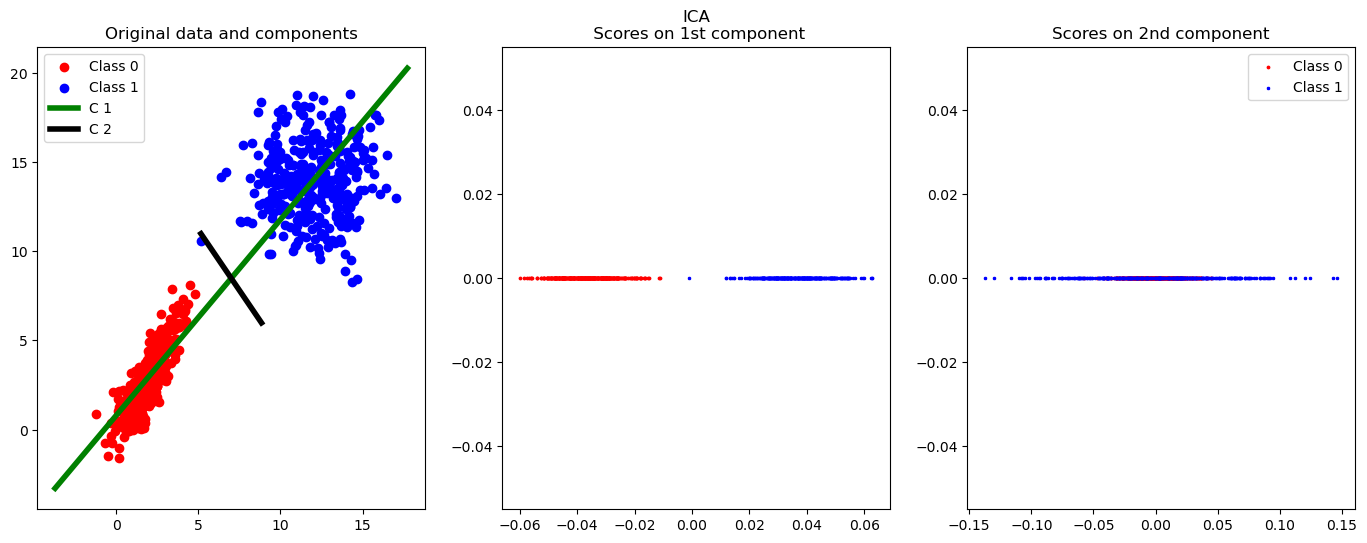

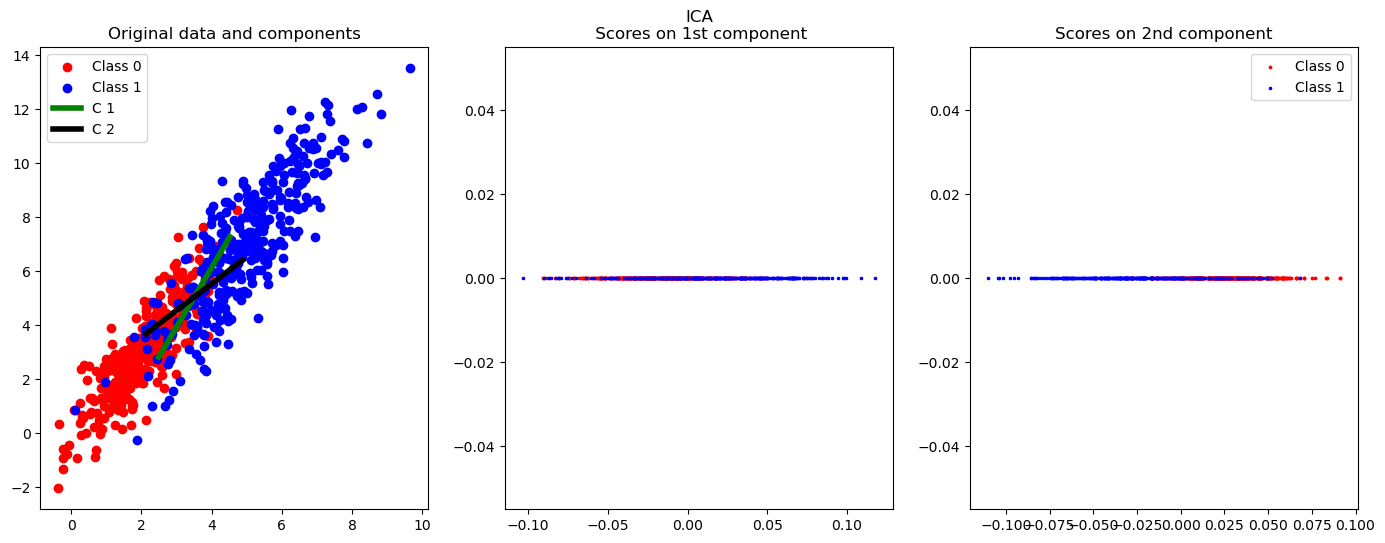

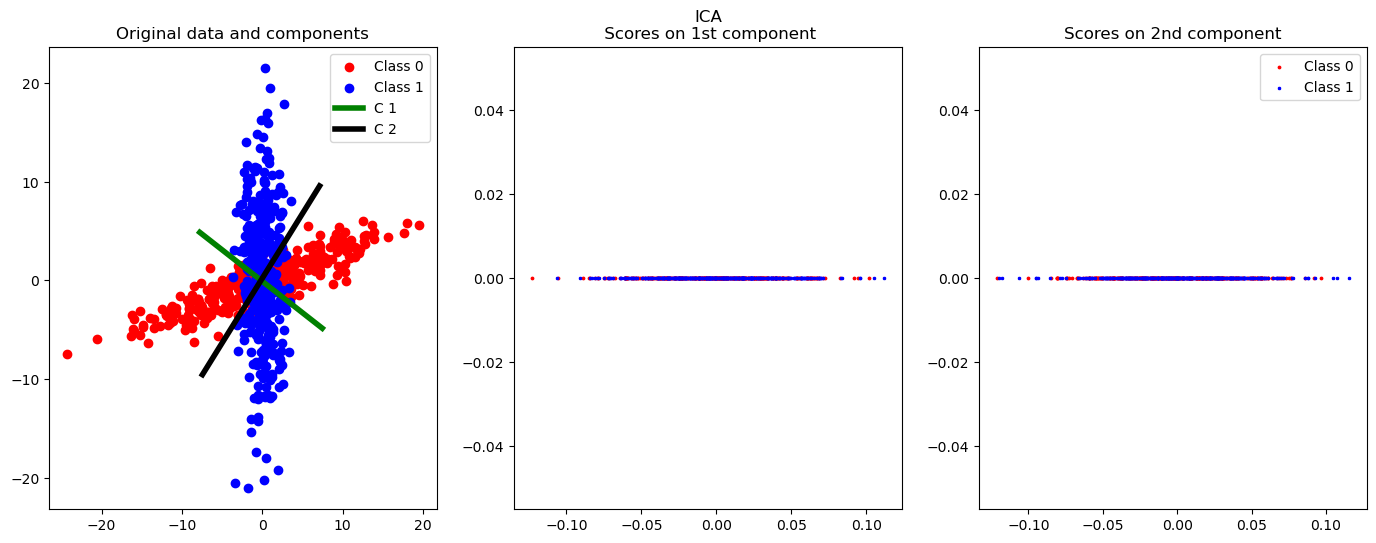

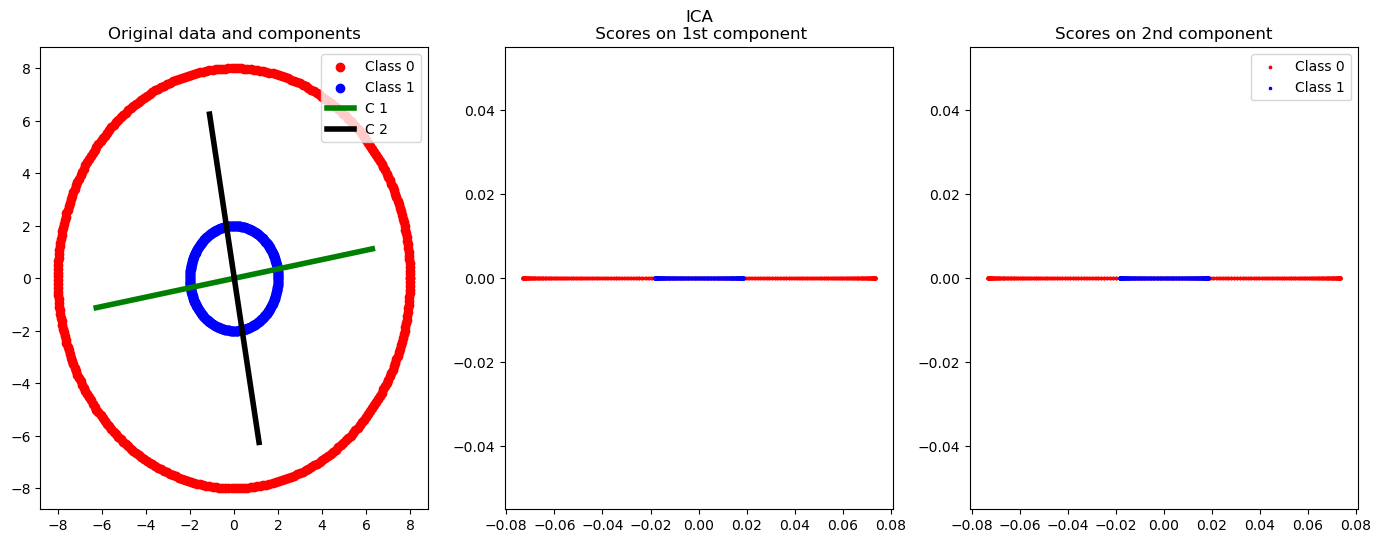

In [16]:
## ICA
scenarioIndex = 1
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
ICA= FastICA(whiten='arbitrary-variance', fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Wica=ICA.mixing_
plotResults(X0=X0,X1=X1,y=y,U=Wica,Y=Yica,const=0.01,title='ICA')



scenarioIndex = 2
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
ICA= FastICA(whiten='arbitrary-variance', fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Wica=ICA.mixing_
plotResults(X0=X0,X1=X1,y=y,U=Wica,Y=Yica,const=0.01,title='ICA')




scenarioIndex = 3
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
ICA= FastICA(whiten='arbitrary-variance', fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Wica=ICA.mixing_
plotResults(X0=X0,X1=X1,y=y,U=Wica,Y=Yica,const=0.01,title='ICA')




scenarioIndex = 4
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
ICA= FastICA(whiten='arbitrary-variance', fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Wica=ICA.mixing_
plotResults(X0=X0,X1=X1,y=y,U=Wica,Y=Yica,const=0.01,title='ICA')

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own !
Complete the code where you see **XXXXXXXXXXXXXX**

In [17]:
def FastICALecture(X,N_Iter=3000,tol=1e-5,plot_evolution=0):
    '''
    Inputs: 
                   X: is a [d x N] matrix. Every column is an observation 
                   and every row is a feature.       
    
                   (Optional) N_Iter: maximum number of iterations
    
                   (Optional) delta: convergence criteria threshold
    
                   (Optional) plot_evolution: plot evolution of error
                   
     Outputs:      
                   S: [d x N] matrix.  Each column is an independent component 
                   of the centred and whitened input data X              
                   
                   W: [d x d] matrix. It is the demixing matrix. S = W*Xcw 
    
    '''
    
    # We choose G=-exp(-1/2t^2)
    # First derivative of G   
    def g(t):
       return t * np.exp(-0.5 * t**2)
        
    # Second derivative of G 
    def gp(t):
        return -(1 - t**2) * np.exp(-0.5 * t**2)
    
    # Size of X
    d,N=X.shape 
        
    # Compute sample mean
    mu = np.mean(X, axis=1, keepdims=True)
    
    # Center data
    Xc= X - mu
    
    # Compute covariance matrix
    C = np.cov(X)
    
    # Whiten data
    Xcw=LA.inv(LA.sqrtm(C))@Xc
    
    # check if are whitened
    if np.sum(np.eye(d) - np.abs(np.cov(Xcw)))>1e-10:
        raise NameError('Your whitening transformation does not work...')
    
    # Initialize W
    W = ortho_group.rvs(d) # random orthogonal matrix 
    
    # delta evolution
    k = 0
    delta = np.inf
    evolutionDelta=[]
    
    while delta > tol and k < N_Iter:
    
        k = k + 1
        W_old = np.copy(W)
        
        Wp =  g(W @ Xcw) @ Xcw.T - np.diag(gp(W @ Xcw) @ np.ones(N)) @ W
        W =  np.linalg.inv(LA.sqrtm(Wp @ Wp.T)) @ Wp
        if np.sum(np.eye(d)-np.abs(np.dot(W,W.T)))>1e-10:
            raise NameError('W should be an orthogonal matrix. Check the computations')
                 
        delta = 1-np.min(np.abs(np.diag(np.dot(W.T,W_old))))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration ICA number ', k, ' out of ', N_Iter , ', delta = ', delta)
     
        
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')


    # Independent components
    S = W @ X 

            
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - ICA')
        plt.show()
       
    return S,W,Xcw


Test your own implementation

Iteration ICA number  1  out of  3000 , delta =  0.00021140098941763164
Convergence achieved ( delta =  7.84166757750171e-06 ) in  10  iterations


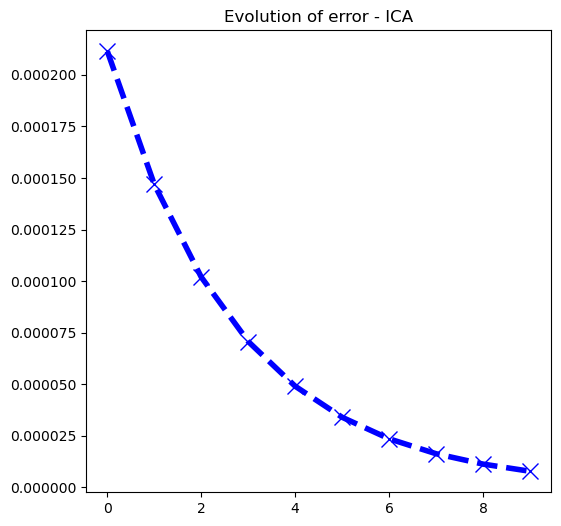

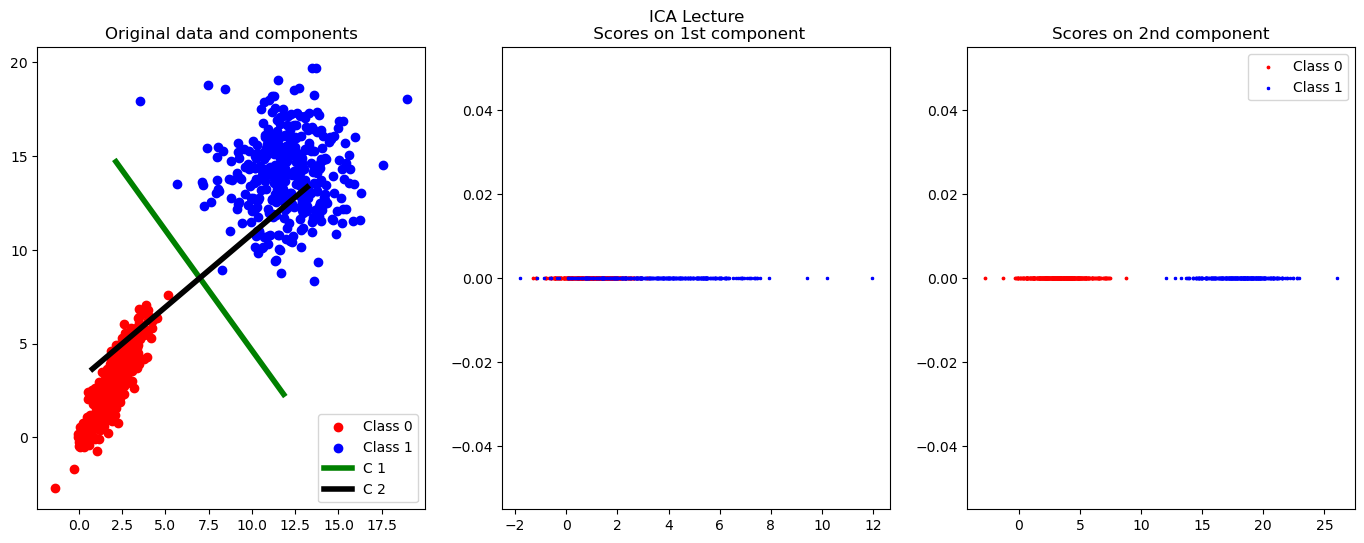

Iteration ICA number  1  out of  3000 , delta =  3.444872279656508e-06
Convergence achieved ( delta =  3.444872279656508e-06 ) in  1  iterations


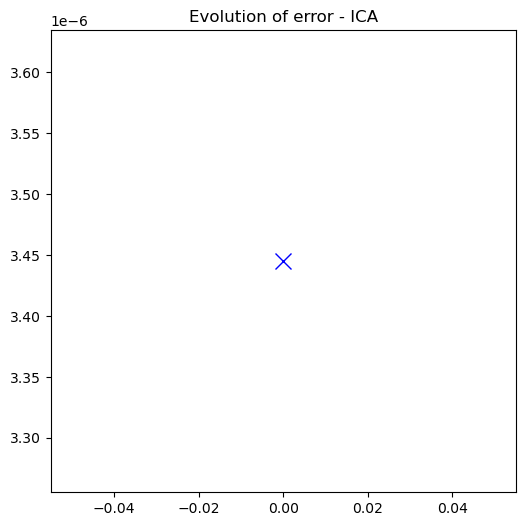

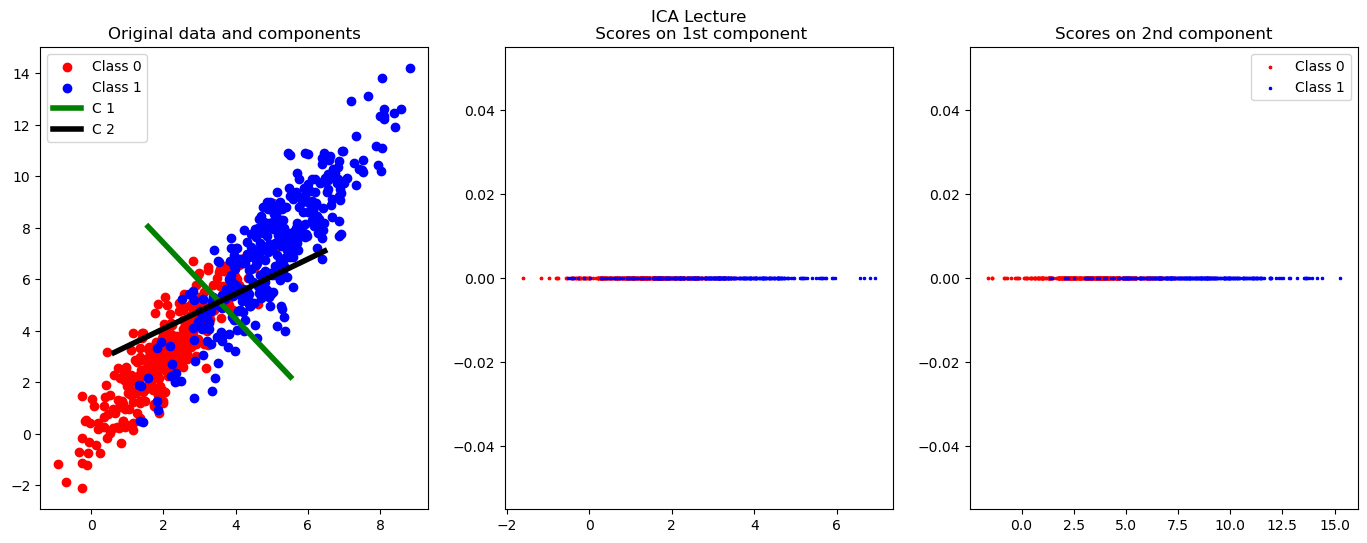

Iteration ICA number  1  out of  3000 , delta =  0.0020036747558014323
Convergence achieved ( delta =  7.116152912045592e-06 ) in  4  iterations


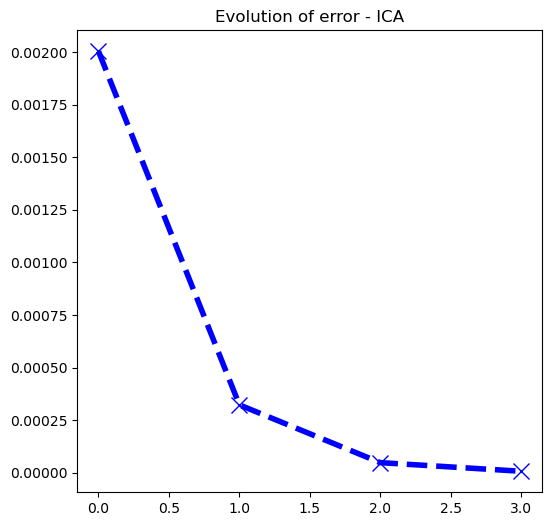

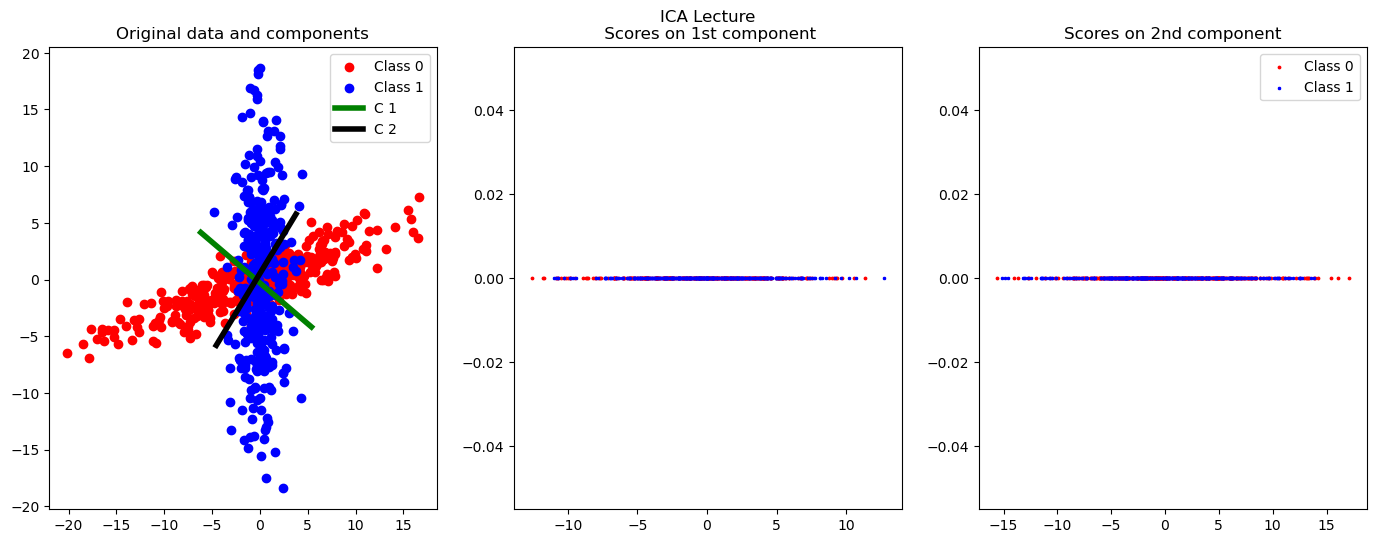

Iteration ICA number  1  out of  3000 , delta =  2.300314145831095e-07
Convergence achieved ( delta =  2.300314145831095e-07 ) in  1  iterations


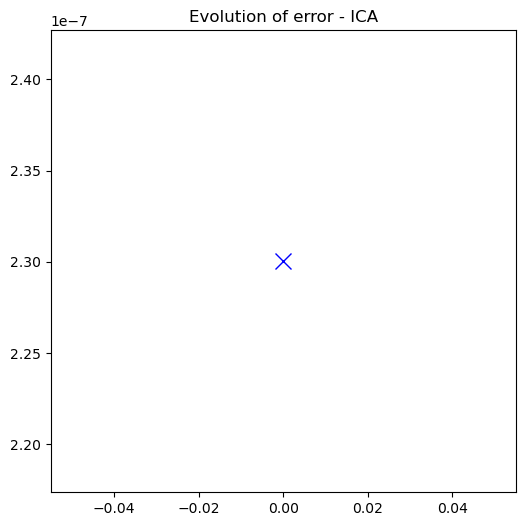

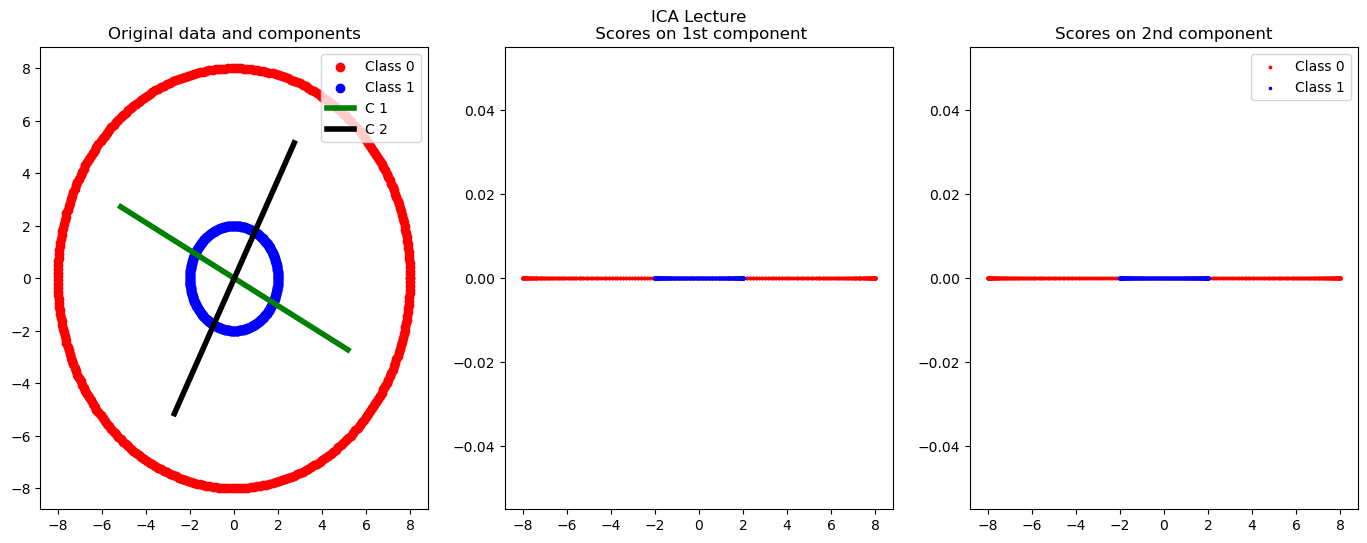

In [18]:
scenarioIndex = 1
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
SicaLec,WicaLec,Xwh = FastICALecture(X.T,N_Iter=3000,tol=1e-5,plot_evolution=1)
plotResults(X0=X0,X1=X1,y=y, U=WicaLec.T, Y=SicaLec.T, const=1, title='ICA Lecture')

scenarioIndex = 2
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
SicaLec,WicaLec,Xwh = FastICALecture(X.T,N_Iter=3000,tol=1e-5,plot_evolution=1)
plotResults(X0=X0,X1=X1,y=y, U=WicaLec.T, Y=SicaLec.T, const=1, title='ICA Lecture')


scenarioIndex = 3
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
SicaLec,WicaLec,Xwh = FastICALecture(X.T,N_Iter=3000,tol=1e-5,plot_evolution=1)
plotResults(X0=X0,X1=X1,y=y, U=WicaLec.T, Y=SicaLec.T, const=1, title='ICA Lecture')


scenarioIndex = 4
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
SicaLec,WicaLec,Xwh = FastICALecture(X.T,N_Iter=3000,tol=1e-5,plot_evolution=1)
plotResults(X0=X0,X1=X1,y=y, U=WicaLec.T, Y=SicaLec.T, const=1, title='ICA Lecture')


# II - True image dataset and face recognition
## II - 1) Dataset

**Goal**
The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning as a preprocessing for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

Let's load the data.

In [19]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="/home/luiz/Documents/Telecom Paris/IMA/IM05 - Apprentissage pour l'image"   

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


Below is a useful function to plot the basis images. Be careful, each row of data is a basis image.

In [20]:
def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())
  

Let's load the data and compute some parameters.

In [21]:
x = loadmat(Working_directory + '/YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')

There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


Let's plot first 10 images of different subjects and then 10 images of the same subject but with different positions and illumination conditions

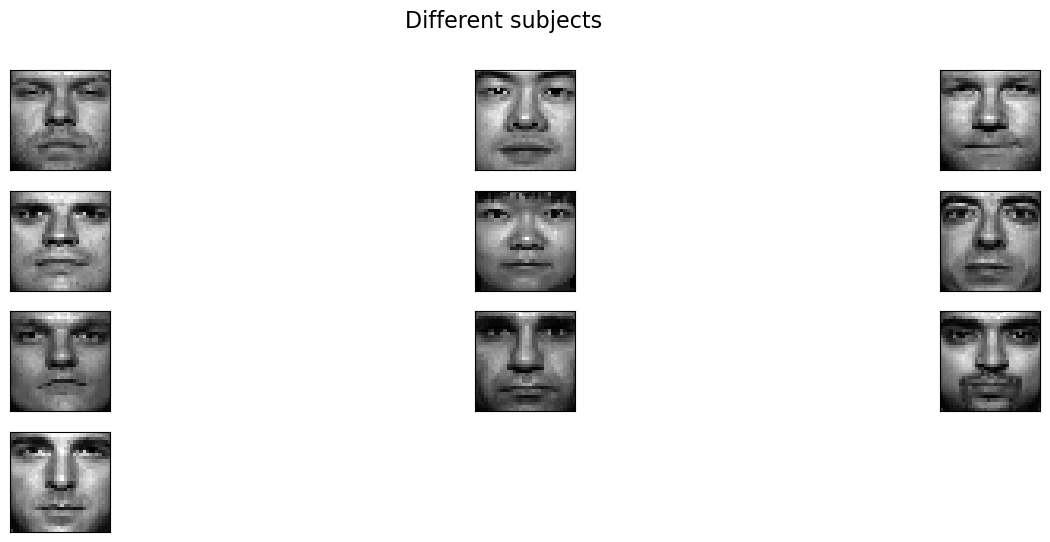

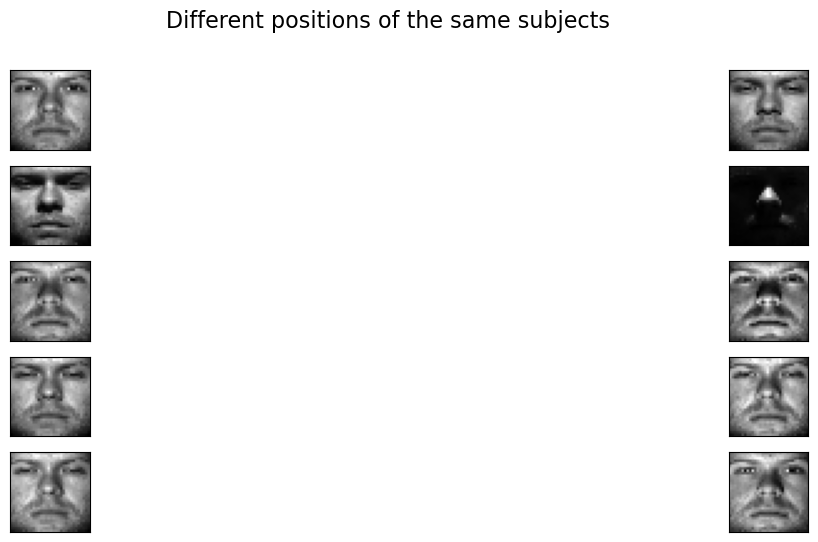

In [22]:
# Plot data      
indexDifferent=np.arange(1,Is*40,Is)     
plotFaces(data,r,c,ncol=3,indeces=indexDifferent[0:10],title='Different subjects')       
indexSame=np.arange(0,10,1)      
plotFaces(data,r,c,ncol=2,indeces=indexSame,title='Different positions of the same subjects')       


We can now move on to evaluate the  performance of the dimensionality reduction techniques presented this morning for face recognition. We first divide the data-set into two parts, training (80%) and test (20%) in a stratified way (subjects are divided in a balanced way between the two parts).

We will see in the next lectures why we need to divide into training and test sets. For now, just know that we will use the first set to train our algorithm and the second set to test the performance of our algorithm on new, unseen data.



In [23]:
Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest = Xtest - np.mean(Xtest, axis=0)# centering
Xctrain= Xtrain - np.mean(Xtrain, axis=0) # centering

As first idea, we could simply use the pixel intensities as features for the classification. This is basically like using the original data, without dimensionality reducton techniques.
In the following, we will use the nearest-neighboor algorithm to perform the classification task. For each test sample, the nearest neighbor algorithm simply looks for the closest training sample and then assigns the same label (i.e. index of subject).

In [24]:
## Use the pixel intensities to find the correct subject for the test images
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Xctrain,Id_Train.ravel())
print('By using the pixel intensities, we use ', Xctrain.shape[1], ' features')
print('Percentage of correct answer using the pixel intensities is ', NN.score(Xctest,Id_Test))



By using the pixel intensities, we use  1024  features
Percentage of correct answer using the pixel intensities is  0.7412008281573499


# II - 2) PCA
**Preliminary part:** We can use PCA to investigate the main variations within the data.

**Question:**
1. How many modes do you need to explain at least 80% of the variability in the data ?
3. Look at the three main modes and explain which are the main variations in the data.

**Answers**

1. 5 modes are needed
2. In the first mode, the main variations occur in the brightness of the cheeks and nose. The second mode primarily captures differences in lighting between the left and right sides of the face. The third mode reflects changes in the overall contrast of the facial features.

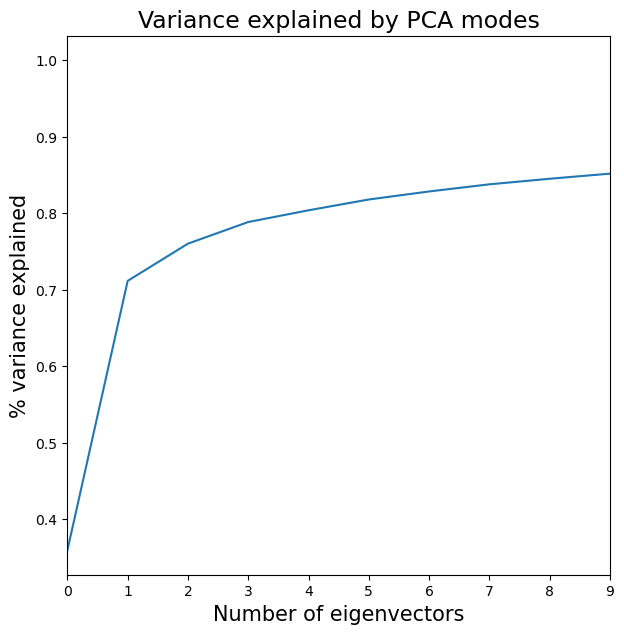

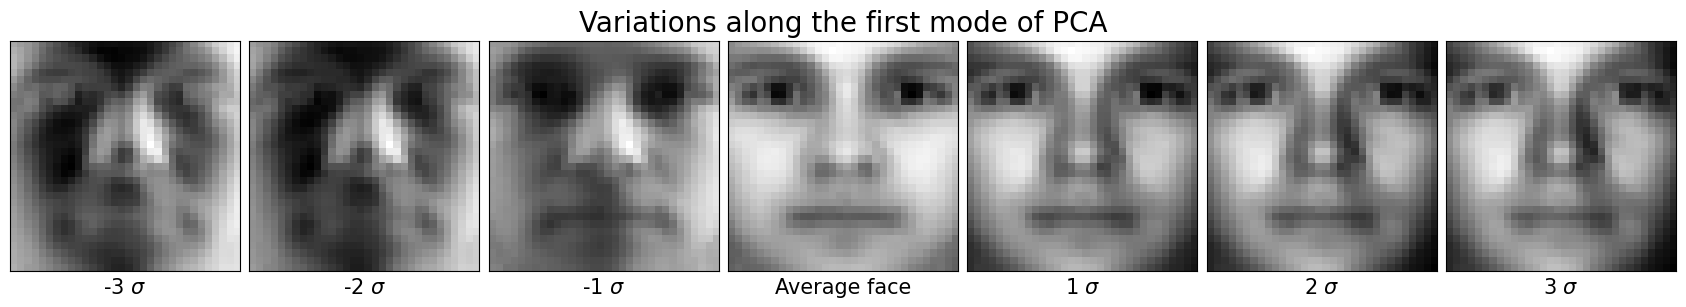

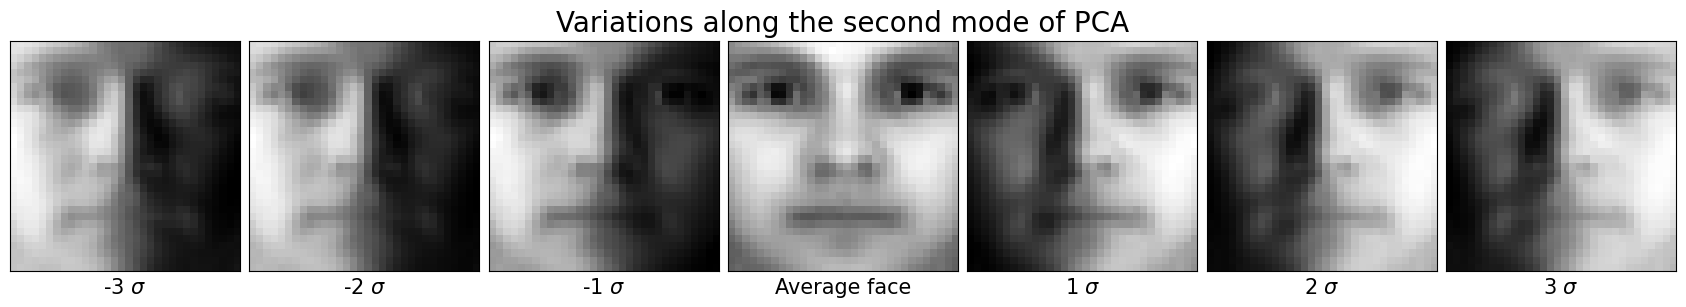

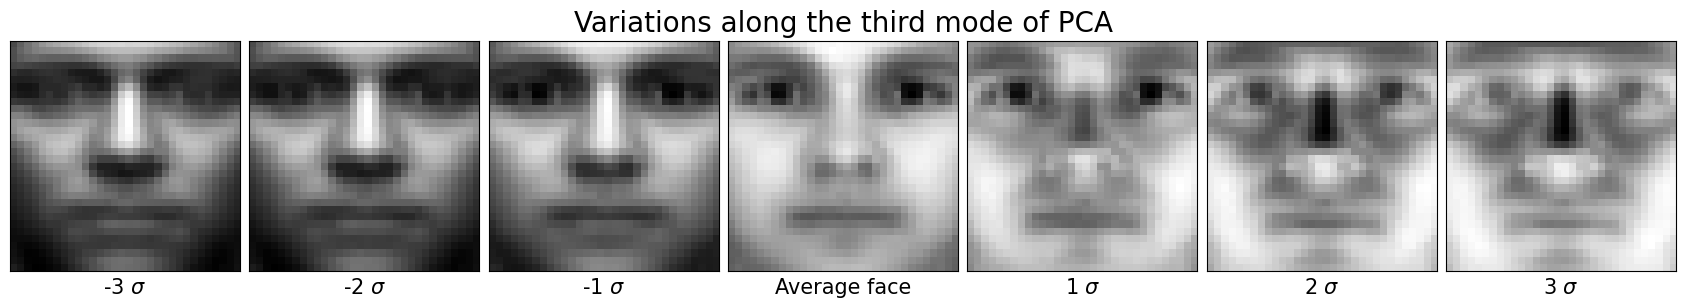

In [25]:
# Linear interpolation along the first two modes
Xm=data.mean(axis=0) # average face
YpcaTrain,UpcaTrain,DpcaTrain,var_explained_pca=pcaLecture(data)
indices=np.linspace(-3, 3, num=7, dtype=np.int16) # Interpolation indices

# Variance explained by each eigenvector
fig=plt.figure(figsize=(7, 7))
ax=plt.subplot(111)
ax.set_xlim(0, 9)
dim=np.arange(0,10,1)
plt.plot(np.cumsum(var_explained_pca))
plt.xticks(dim)
plt.xlabel('Number of eigenvectors',fontsize=15)
plt.ylabel('% variance explained',fontsize=15)
plt.title('Variance explained by PCA modes',fontsize=17)

## First mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the first mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index * np.sqrt(DpcaTrain[0]) * UpcaTrain[:,0]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)


## Second mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the second mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index * np.sqrt(DpcaTrain[1]) * UpcaTrain[:,1]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

## Third mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the third mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index * np.sqrt(DpcaTrain[2]) * UpcaTrain[:,2]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

**PCA as a preprocessing for classification:**

Now, we can employ PCA as a preprocessing step before classification. You will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 




Precisely, using PCA, compute the scores $Y_{train}$, eigenvectors $U_{train}$ and eigenvalues $D_{train}$ of the training set. The eigenvectors $U_{train}$ represent the basis images and they are usually called *'Eigenfaces'*. Then, project both training and test data onto the eigenvectors that explain 99$\%$ of the variability of the training set $L_{train}^{99}$. You will obtain two vectors of scores, $Y_{train}^{99}=X_{train} L_{train}^{99}$ and $Y_{test}^{99}=X_{test} L_{test}^{99}$, which you will use for evaluating the performance of the algorithm. Use the function `KNeighborsClassifier` to test the performance.

**Practical Questions:** 

1. Use the scikit-learn implementation to test the performance, as previously explained. Furthermore, please comment the eigenfaces. Do they seem "real" ?

Answer: No, they do not appear to be real images. Eigenfaces are not actual facial images but rather mathematical representations of the directions in which the data varies the most. They are vectors that define key patterns in the dataset rather than detailed facial features.

**Theoretical Questions:** 

1. In your opinion, why do we need to center the data before computing a PCA ? If you want, you can use the previous toy examples to answer this question.
2. Let $X$ be the original data, a matrix $\left[ N,d \right]$, and $Y$ the scores of a PCA keeping all eigenvectors, which means that $Y$ is also a matrix $\left[ N,d \right]$. Are $X$ and $Y$ equal ? If not, why ? What would you use (generally speaking) in a machine learning problem ? Why ?
3. Let $x_p$ and $x_q$ be two row-vectors representing two images, $U$ an *orthogonal* matrix whose columns are the eigenvectors of $X$ and $y_p=x_pU$, $y_q=x_qU$, check that $x_px_q^T=y_py_q^T$. This shows that $Y=XU$ is a linear transformation that preserves inner products.
4. Let $C$ be the covariance matrix of $X$ and $C=UDU^T$ its eigen decomposition. Show that the covariance matrix of $Y=XU$ is $D$.

**Answers**

1. Before computing PCA, we center the data by subtracting the mean of each feature. This is necessary because PCA finds directions of maximum variance, and if the data is not centered, the first principal component may be biased toward the mean rather than capturing actual variations in the data. Centering ensures that the principal components reflect the true structure of the data rather than being influenced by absolute values.

2. No, X and Y are not the same. Y is a new representation where the features are uncorrelated and ordered by their importance in explaining variance. Even when keeping all eigenvectors, the values in Y are different because they represent the data in a new basis. In machine learning, we usually want to use Y with only a subset of the most important components to reduce dimensionality, improve efficiency, and remove noise.

3. Since U  is an orthogonal matrix, it has the property that $U^T U = I $. Given the transformation $y_p = x_p U $ and $ y_q = x_q U $, we compute the inner product:

$$
y_p y_q^T = (x_p U) (x_q U)^T = x_p U U^T x_q^T
$$

Since $U U^T = I $, this simplifies to:

$$
y_p y_q^T = x_p x_q^T
$$

This shows that PCA is a linear transformation that preserves inner products, meaning that distances and angles between data points remain unchanged.

4. The covariance matrix of  X  is given by:

$$
C = \frac{1}{N-1} X^T X
$$

Since C has the eigen decomposition  $C = U D U^T$ , we compute the covariance matrix of $Y = XU$ :

$$
\text{Cov}(Y) = \frac{1}{N-1} (XU)^T (XU)
$$

Expanding this:

$$
\text{Cov}(Y) = U^T \left( \frac{1}{N-1} X^T X \right) U
$$

Since $ C = \frac{1}{N-1} X^T X $, we substitute:

$$
\text{Cov}(Y) = U^T C U = U^T (U D U^T) U
$$

Using the orthogonality property $ U^T U = I $, this simplifies to:

$$
\text{Cov}(Y) = D
$$

This means that in the new PCA-transformed space, the covariance matrix is diagonal, meaning the principal components are uncorrelated and their variances are given by the eigenvalues in D .



PCA uses  233  features
Percentage of correct answer using PCA is  0.7122153209109731


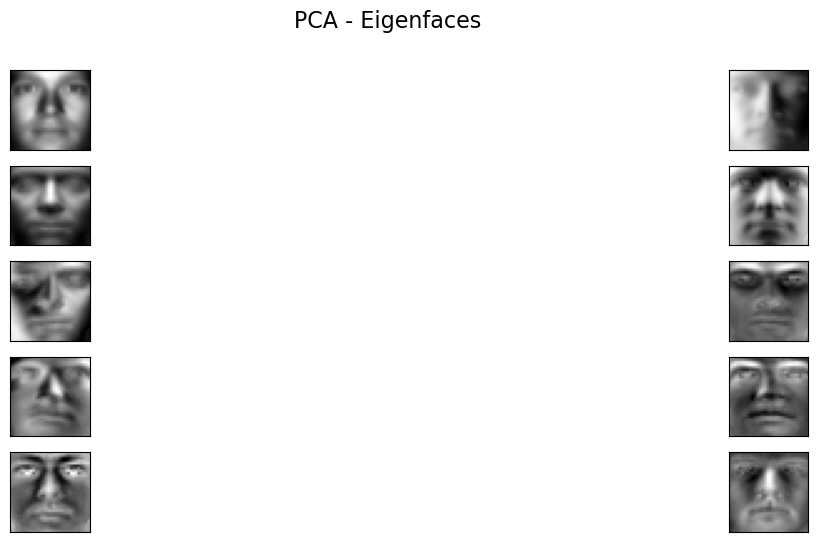

In [26]:
## PCA (scikit-learn implementation)

pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(Xctrain)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(Xctrain.shape[0]-1) # computation of the eigenvalues


# Threshold defined as 99% of the variability
# Cumulative explained variance 
cum_explained_var = np.cumsum(pca.explained_variance_ratio_)
# Number of components before the cumulative explained variance 
# is equal to or exceeds 99%
PCAComp = np.where(cum_explained_var >= 0.99)[0][0] + 1


print('PCA uses ', PCAComp, ' features')

# Selection of the eigenvectors 
selected_U = U[:, :PCAComp]

# Computation of the test scores using the eigenvectors computed with the
# training data-set
Y_train_pca = Xctrain @ selected_U

# Plot the Eigenfaces
plotFaces(selected_U.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='PCA - Eigenfaces')       


# Score: apply the nearest-neighboor algorithm to PCA output
Y_test_pca = Xctest @ selected_U
NN.fit(Y_train_pca, Id_Train.ravel())
accuracy = NN.score(Y_test_pca, Id_Test)
print('Percentage of correct answer using PCA is ', accuracy)


**KPCA**

In this section, we are going to do exactly the same procedure as before but using Kernel-PCA with a Gaussian kernel. Remember that we need to compute and center the test kernel matrix $[\mathbf{\tilde{K}}]_{ij}=<\phi(x_i)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)>$ and that, once computed the basis vectors in the training set $\{  \mathbf{\alpha}_i \}$, we can compute the score for a test sample $t$ using the following equation:

$y_i(t) = \sum_{j=1}^N a_{ij} <\phi(t)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)> = \sum_{j=1}^N a_{ij} \tilde{k}(t,x_j)$

Answer the following questions:

**Questions:** 

1.  Use the scikit-learn implementation to test the performance
2. Look for the best gamma value

By testing a few different values, gamma = 3.5 appears to be the best


4. Why the basis vectors $\{  \mathbf{\alpha}_i \}$ are not plotted as in PCA ?

In PCA, basis vectors (eigenvectors) correspond to linear projections and can be reshaped into images (e.g., Eigenfaces). In KPCA, the basis vectors exist in an implicit high-dimensional space due to the kernel trick, making them non-interpretable in pixel space. Therefore, they cannot be plotted like PCA eigenfaces.


5. Is it worth it, in your opinion, to compute PCA and/or KPCA ? Why not using the original pixel intensities ? Please consider the following aspects in your answer: performance, computational time, number of features, and interpretability of the results.

In this case, raw pixel intensities (0.74) gave better results than both PCA (0.71) and KPCA (0.62), meaning that reducing the number of features removed important details for classification. PCA usually helps by making computations faster and reducing data size, but here it did not improve accuracy. KPCA, which captures more complex patterns, took much longer to compute and still performed the worst. While PCA provides some insight into feature variations, KPCA is harder to interpret. Since PCA and KPCA did not improve accuracy and KPCA increased computational time, using raw pixel intensities is the best choice for this dataset.

6. (Optional) Create a new function `Kpca_poly_lecture` where you change the kernel to $k(x,y)=<x,y>^d$. Evaluate the performance of this new kernel.



In [27]:
# Set gamma value
gamma_val = 3.5

# Apply Kernel PCA
kpca_model = KernelPCA(kernel="rbf", gamma=gamma_val, random_state=1)
Y_train_kpca = kpca_model.fit_transform(Xctrain)
eig_values_kpca = kpca_model.eigenvalues_
eig_vectors_kpca = kpca_model.eigenvectors_

# Compute cumulative variance explained
cum_var_explained = np.cumsum(eig_values_kpca / np.sum(eig_values_kpca))

# Determine number of components to reach 99% variance
num_kpca_components = len(cum_var_explained[cum_var_explained < 0.99])

# Select the top eigenvectors
selected_kpca_eigvecs = eig_vectors_kpca[:, :num_kpca_components]


# Construction matrix K for test
N = Xctrain.shape[0]
M = Xctest.shape[0]
InnerX = np.dot(Xctest, Xctrain.T)
tempTrain = np.sum(Xctrain**2, axis=1).reshape((1, N))
tempTest = np.sum(Xctest**2, axis=1).reshape((M, 1))
NormTrain2 = np.repeat(tempTrain, M, axis=0)
NormTest2 = np.repeat(tempTest, N, axis=1) 
Norm = NormTest2 + NormTrain2 - 2 * InnerX
Norm[Norm < 1e-10] = 0    
Ktest = np.exp(-Norm / (2 * gamma_val**2))

# Centering kernel test matrix
oneN = np.ones((N, N)) / N
oneM = np.ones((M, M)) / M


# Compute test scores using the selected eigenvectors from training
Y_test_kpca = Ktest @ selected_kpca_eigvecs
Y_train_kpca_selected = Y_train_kpca[:, :num_kpca_components]

# Print the number of components used
print('KPCA uses', Y_train_kpca_selected.shape[1], 'features')

# Apply nearest neighbor classification
NN.fit(Y_train_kpca_selected, Id_Train.ravel())
kpca_accuracy = NN.score(Y_test_kpca, Id_Test.ravel())
print('Percentage of correct answer using KPCA is', kpca_accuracy)


KPCA uses 1901 features
Percentage of correct answer using KPCA is 0.6169772256728778


# II - 3) ICA (optional part)

In the next section you will evaluate ICA. Every image $x_i$ can be seen as a linear combination of basis images. ICA can be used in two different ways for face recognition. We can look for a set of statistically independent basis images $s_j$ (first architecture) or for a set of statistically independent coefficients $a_{j}$ (second architecture).

In the first architecture, we compute $X'=A'S'$, where every row of $X'$ is an image and the columns are pixels. Images are considered as random variables and we look for a set of statistically independent basis images contained in the rows of $S'$.

In the second architecture, we transpose the previous setting computing $X''=A''S''$, where every column of $X''$ is an image and rows are pixels. In this case, we consider the pixels as random variables and we look for a set of statistically independent coefficients contained in the rows of $S$ and a set of basis images in the columns of $A$.

Instead than using the original training data $X$ as input matrix, we are going to use the eigenvectors (first architecture) or the scores (second architecture) computed with PCA, namely $Y=XL$ (same notation as in the slides of the lecture). In this way, we reduce the computational time since the number of eigenvectors that account for 99\% of the variance of the training images (columns of $L$) is definitely lower than the number of pixels (columns of $X$). If you want, you can of course use the original data but it will take much more time to converge.

For the first architecture we will use $L^T$ as input matrix. In fact, we can notice that the PCA approximation of the matrix $X_{train}$, containing an image in every row, can be written as $\tilde{X} = YL^T$. If we use $L^T$ as input in the ICA algorithm we obtain $L^T=AS$, thus it follows that $\tilde{X}=YW^TS$ (since $A=W^{-1}=W^T$). The basis images are contained in the rows of $S$ and the coefficients used for evaluating the performance are instead contained in the rows of $Y_{train}W^T$ for the training set and in $Y_{test}W^T$ for the test set.

For the second architecture, we will instead use $Y^T$ as input matrix thus obtaining $Y^T=AS$. Remember that in the second architecture we want to apply the ICA algorithm to the transpose of $X_{train}$. We can notice that, given the PCA transformation $Y=XL$, one can write $X \approx YL^T$ which entails $X^T \approx LY^T=LAS=LW^TS$. The columns of $LW^T$ contain the basis images whereas the columns of $S$ contain the statistically independent coefficients used to test the performance of the algorithm. The coefficients for the test set are in the columns of $S_{test}=W_{train}Y_{test}^T$.

NB: Here we used $X=X_c$ which means centered face images

**Questions:**
 
1. Use the scikit-learn implementation to test the performance of the two architectures
2. Look at the results of the two architecures. Which one is better ?
3. Looking at the basis images, in which case do they seem more 'real' ?



In [28]:
#first architecture (scikit-learn implementation)
# First apply PCA as a preprocessing for ICA
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX

# We use the PCA projection to speed up results
# Threshold defined as 99% of the variability
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX

# Selection of the eigenvectors 
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX

# Apply ICA
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX

Y_test_ICA= XXXXXXXXXXXX
Y_train_ICA = XXXXXXXXXXXX

print('ICA uses ', Y_train_ICA.shape[1], ' features')

# Plot the Eigenfaces
plotFaces(XXXXXXXXXXXX,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA - first architecture')  

# Score
NN.fit(XXXXXXXXXXXX,Id_Train.ravel())
print('Percentage of correct answer using ICA arch.1 is ', NN.score(Y_test_ICA,Id_Test.ravel()))


NameError: name 'XXXXXXXXXXXX' is not defined

In [ ]:
# Second architecture (scikit-learn implementation)
# To be done
